In [ ]:
"""
Drug–Target Interaction Prediction & Visualization
--------------------------------------------------

Objective:
    Screen natural product ingredients against key protein targets
    related to consumer-relevant functions:
      - ADORA2A (alertness / sleep-wake regulation)
      - MAOA (mood regulation)
      - TAS1R2 (sweet taste perception)

    The goal is to predict which molecules may bind to these proteins
    using the DeepPurpose library and visualize the results.

What this script does:
    1. Loads pre-computed prediction CSVs for each target.
    2. Generates bar charts of the Top 10 predicted binders.
    3. Creates a cross-target comparison plot for overlapping ingredients.
    4. Shows the score distribution across all three targets.

Inputs:
    - CSV files: results_TAS1R2.csv, results_ADORA2A.csv, results_MAOA.csv
      Each file should contain: Ingredient, SMILES, score

Outputs:
    - Plots displayed interactively (can also be saved as PNG if needed)
    - Useful for reporting and interpretation of prediction results.
"""


# Installing necessary libraries

In [ ]:
!pip install DeepPurpose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.9/779.9 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 17.4 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/bp-kelley/descriptastorus pandas-flavor

  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-r8nnwmtj
  Running command git clone --filter=blob:none --quiet https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-r8nnwmtj
  Resolved https://github.com/bp-kelley/descriptastorus to commit 9a190343bcd3cfd35142d378d952613bcac40797
  Preparing metadata (setup.py) ... done
  Created wheel for descriptastorus: filename=descriptastorus-2.7.0.3-py3-none-any.whl size=1082893 sha256=ba460f2020fde8583c860c49537c41cd0628da86615934c4974bf7d05e99fbff
  Stored in directory: /tmp/pip-ephem-wheel-cache-oxj4uhkn/wheels/a5/37/b0/bc8b04ad2a1d1f3e17a7bff134d2a7e63621914e0a01d983a6
Successfully built descriptastorus


In [ ]:

pip install DeepPurpose torch pandas requests


In [ ]:


pip install --upgrade DeepPurpose

# Data Engineering & Analytics

In [ ]:
# Loading Dataset Source
df=pd.read_csv('/dsld_ingredients_with_smiles.csv')

In [ ]:
# Top 5 Rows of the Dataset
df.head()

,Ingredient,SMILES
0,riboflavin,CC1=CC2=C(C=C1C)N(C3=NC(=O)NC(=O)C3=N2)CC(C(C(...
1,vitamin b6,CC1=NC=C(C(=C1O)CO)CO
2,vitamin c,C(C(C1C(=C(C(=O)O1)O)O)O)O
3,citrus bioflavonoids,NaN
4,rose hips,NaN


In [37]:
# Rows & Columns
df.shape

(68983, 2)

In [ ]:
# Finding the Number of Null Values in the Dataset
df.isnull().sum()

,0
Ingredient,0
SMILES,66246


In [ ]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68983 entries, 0 to 68982
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ingredient  68983 non-null  object
 1   SMILES      2737 non-null   object
dtypes: object(2)
memory usage: 1.1+ MB


In [ ]:
# Type of Each Column
df.dtypes

,0
Ingredient,object
SMILES,object


# Main Program

In [ ]:
import pandas as pd
import requests
import logging
import os
from DeepPurpose import utils, dataset, DTI

# -------------------
# CONFIGURATION
# -------------------
CSV_PATH = "/dsld_ingredients_with_smiles.csv"
OUTPUT_FOLDER = "/predictions/"

TARGETS = {
    "ADORA2A": "P29274",  # Alertness
    "MAOA": "P21397",     # Mood
    "TAS1R2": "Q8TE23"    # Sweet taste
}

# Ensure output folder exists
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

logging.basicConfig(
    filename="screening.log",
    filemode="w",
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.INFO
)

# -------------------
# HELPER
# -------------------
def fetch_uniprot_fasta(uniprot_id):
    """Fetch protein FASTA sequence from UniProt."""
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
    response = requests.get(url)
    response.raise_for_status()
    seq = "".join([line.strip() for line in response.text.split("\n") if not line.startswith(">")])
    return seq

# -------------------
# LOAD MOLECULES
# -------------------
df = pd.read_csv(CSV_PATH)
df_valid = df[df["SMILES"].notna() & (df["SMILES"].str.strip() != "")]
print(f"Found {len(df_valid)} valid molecules out of {len(df)} total.")
logging.info(f"Valid molecules: {len(df_valid)} / {len(df)}")

# -------------------
# DEFINE MODEL (CNN encoders → no RDKit required)
# -------------------
drug_encoding = "CNN"
target_encoding = "CNN"

config = utils.generate_config(
    drug_encoding=drug_encoding,
    target_encoding=target_encoding,
    cls_hidden_dims=[1024, 1024, 512],
    train_epoch=0,  # prediction only
    LR=0.001,
    batch_size=128
)
from DeepPurpose import DTI

print("Loading pretrained model...")

model = DTI.model_pretrained(model='cnn_cnn_bindingdb') # Corrected model name





# -------------------
# RUN PREDICTIONS
# -------------------
for target_name, uniprot_id in TARGETS.items():
    try:
        print(f"\nProcessing target {target_name} ({uniprot_id})...")
        seq = fetch_uniprot_fasta(uniprot_id)

        smiles_list = df_valid["SMILES"].tolist()
        names_list = df_valid["Ingredient"].tolist()
        target_list = [seq] * len(smiles_list)

        # Build dataset for prediction
        X_pred = dataset.data_process(
            X_drug=smiles_list,
            X_target=target_list,
            y=[0] * len(smiles_list),  # dummy labels
            drug_encoding=drug_encoding,
            target_encoding=target_encoding,
            split_method="no_split"
        )

        # Run predictions
        scores = model.predict(X_pred)

        # Save sorted results
        results_df = pd.DataFrame({
            "Ingredient": names_list,
            "SMILES": smiles_list,
            "score": scores
        }).sort_values(by="score", ascending=True)

        out_path = os.path.join(OUTPUT_FOLDER, f"results_{target_name}.csv")
        results_df.to_csv(out_path, index=False)
        print(f"[OK] {target_name} predictions saved to {out_path}")

    except Exception as e:
        logging.error(f"Error with {target_name}: {e}")
        print(f"[ERROR] {target_name} failed: {e}")

print("\n✅ All predictions complete. See 'predictions/' folder for results.")

Found 2737 valid molecules out of 68983 total.
Loading pretrained model...
pretrained model Successfully Downloaded...

Processing target ADORA2A (P29274)...
Drug Target Interaction Prediction Mode...
in total: 2737 drug-target pairs
encoding drug...
unique drugs: 1687
encoding protein...
unique target sequence: 1
splitting dataset...
do not do train/test split on the data for already splitted data
predicting...
[OK] ADORA2A predictions saved to /content/drive/MyDrive/Molecule/predictions/results_ADORA2A.csv

Processing target MAOA (P21397)...
Drug Target Interaction Prediction Mode...
in total: 2737 drug-target pairs
encoding drug...
unique drugs: 1687
encoding protein...
unique target sequence: 1
splitting dataset...
do not do train/test split on the data for already splitted data
predicting...
[OK] MAOA predictions saved to /content/drive/MyDrive/Molecule/predictions/results_MAOA.csv

Processing target TAS1R2 (Q8TE23)...
Drug Target Interaction Prediction Mode...
in total: 2737 drug

# Uploading Prediction CSV Files

In [ ]:
tas1r2=pd.read_csv('/results_TAS1R2.csv')

In [ ]:
tas1r2.head().sort_values(by='score', ascending=False)

,Ingredient,SMILES,score
4,sodium chlorite,[O-]Cl=O.[Na+],3.378455
3,choline,C[N+](C)(C)CCO,3.370037
2,choline bitartrate,C[N+](C)(C)CCO,3.370037
1,alpha-keto glutarate,C1CC(=O)OOOC(=O)C1,3.354184
0,2-cyclohexylethylamine,C1CCC(CC1)CCN,3.194253


In [ ]:
maoa=pd.read_csv('/predictions/results_MAOA.csv')

In [ ]:
maoa.head().sort_values(by='score', ascending=False)

,Ingredient,SMILES,score
4,delete,CCCCCCCCCCO,2.929253
3,2-cyclohexylethylamine,C1CCC(CC1)CCN,2.882701
2,cesium chloride,[Cl-].[Cs+],2.869726
0,caprylic acid,CCCCCCCC(=O)O,2.735448
1,octanoic acid,CCCCCCCC(=O)O,2.735448


In [ ]:
adora2a=pd.read_csv('/predictions/results_ADORA2A.csv')

In [ ]:
adora2a.head().sort_values(by='score', ascending=False)

,Ingredient,SMILES,score
4,alpha-keto glutarate,C1CC(=O)OOOC(=O)C1,2.720205
3,caprylic acid,CCCCCCCC(=O)O,2.685745
2,octanoic acid,CCCCCCCC(=O)O,2.685745
1,sodium nitrite,N(=O)[O-].[Na+],2.631878
0,2-cyclohexylethylamine,C1CCC(CC1)CCN,2.475019


# Plotting

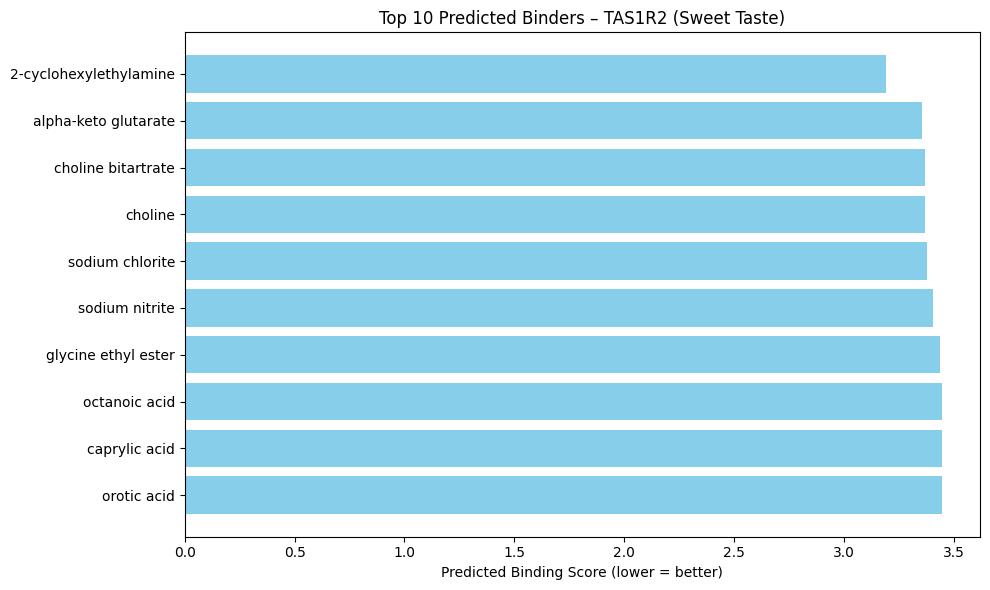

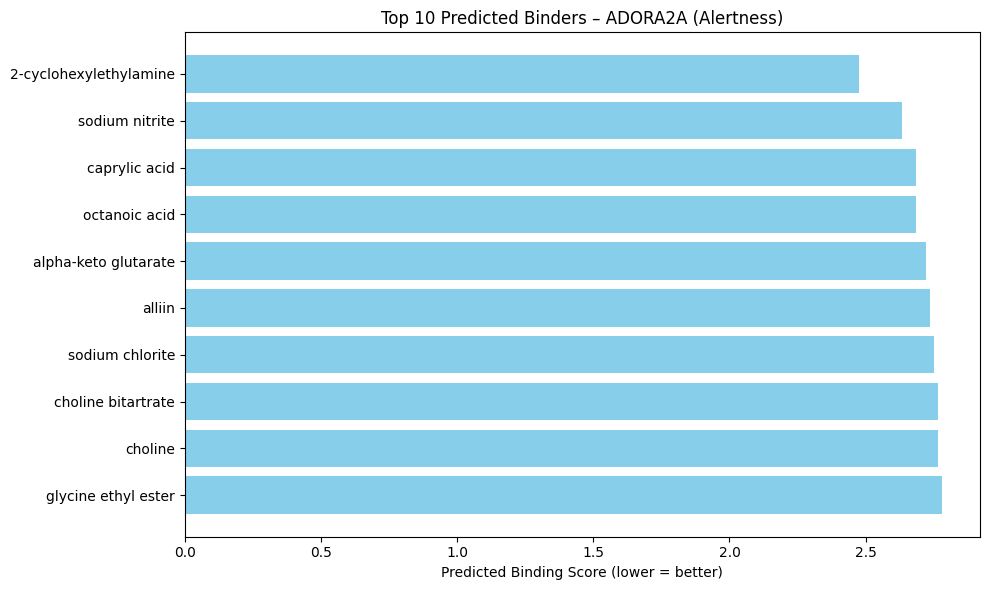

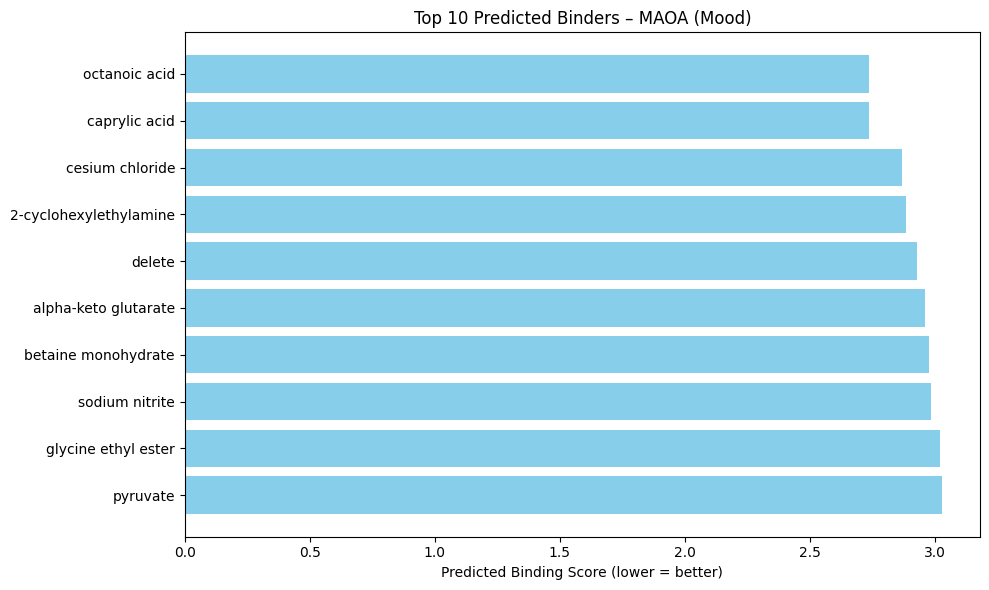

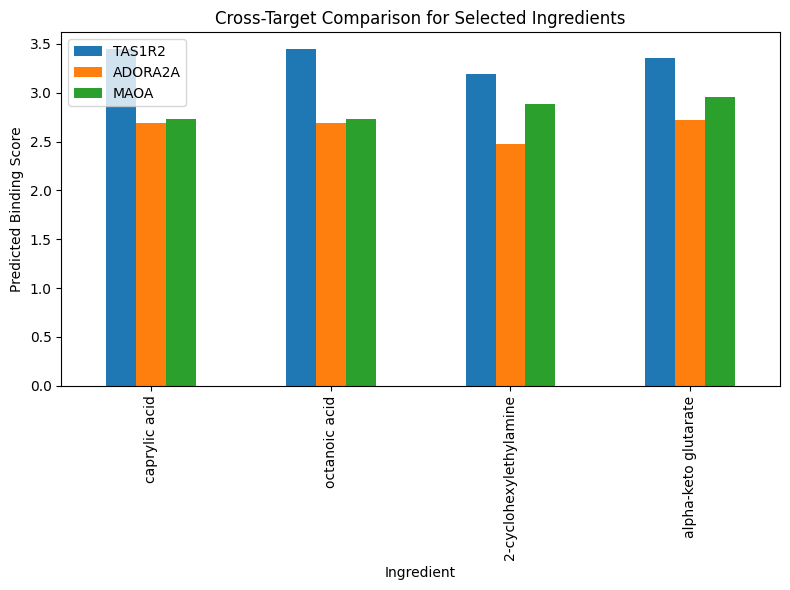

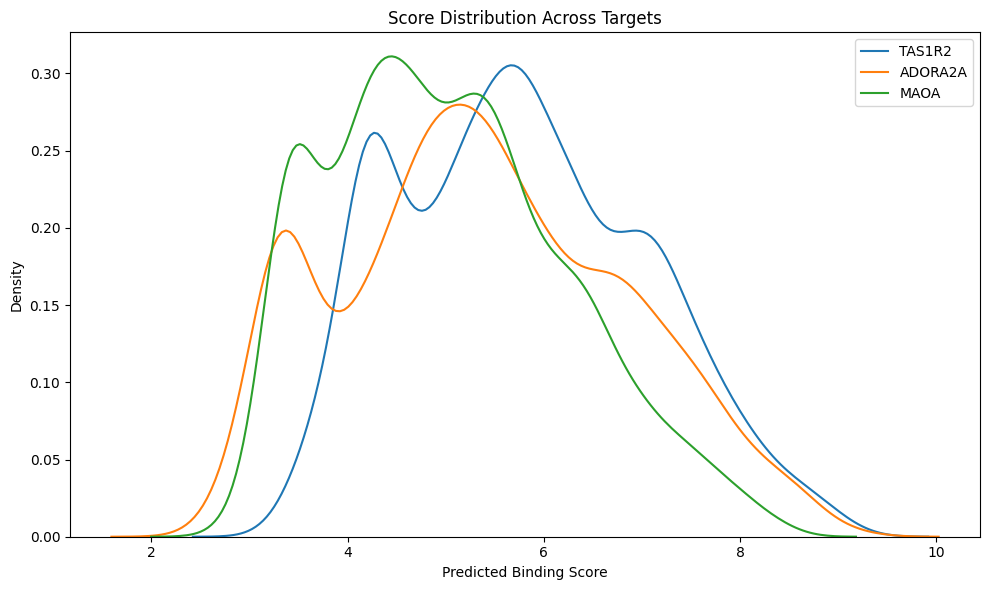

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------
# Load Results
# -------------------
tas1r2 = pd.read_csv("/results_TAS1R2.csv")
adora2a = pd.read_csv("/results_ADORA2A.csv")
maoa = pd.read_csv("/results_MAOA.csv")

# -------------------
# 1. Top 10 per target
# -------------------
def plot_top10(df, target_name):
    top10 = df.sort_values("score").head(10)
    plt.figure(figsize=(10,6))
    plt.barh(top10["Ingredient"], top10["score"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.xlabel("Predicted Binding Score (lower = better)")
    plt.title(f"Top 10 Predicted Binders – {target_name}")
    plt.tight_layout()
    plt.show()

plot_top10(tas1r2, "TAS1R2 (Sweet Taste)")
plot_top10(adora2a, "ADORA2A (Alertness)")
plot_top10(maoa, "MAOA (Mood)")

# -------------------
# 2. Cross-target comparison
# -------------------
common = set(tas1r2["Ingredient"]).intersection(
            set(adora2a["Ingredient"])).intersection(
            set(maoa["Ingredient"]))

# If too many, pick only interesting ones you saw (edit manually if needed)
selected = {"2-cyclohexylethylamine", "alpha-keto glutarate", "caprylic acid", "octanoic acid"}

df_compare = pd.DataFrame({
    "Ingredient": list(selected),
    "TAS1R2": [tas1r2.loc[tas1r2["Ingredient"]==x, "score"].values[0] if x in tas1r2["Ingredient"].values else None for x in selected],
    "ADORA2A": [adora2a.loc[adora2a["Ingredient"]==x, "score"].values[0] if x in adora2a["Ingredient"].values else None for x in selected],
    "MAOA": [maoa.loc[maoa["Ingredient"]==x, "score"].values[0] if x in maoa["Ingredient"].values else None for x in selected]
})

df_compare.set_index("Ingredient").plot(kind="bar", figsize=(8,6))
plt.ylabel("Predicted Binding Score")
plt.title("Cross-Target Comparison for Selected Ingredients")
plt.tight_layout()
plt.show()

# -------------------
# 3. Score Distribution
# -------------------
plt.figure(figsize=(10,6))
sns.kdeplot(tas1r2["score"], label="TAS1R2")
sns.kdeplot(adora2a["score"], label="ADORA2A")
sns.kdeplot(maoa["score"], label="MAOA")
plt.xlabel("Predicted Binding Score")
plt.ylabel("Density")
plt.title("Score Distribution Across Targets")
plt.legend()
plt.tight_layout()
plt.show()
